# Training RNN to Create a Circle

This notebook uses a basic Elman network (see `elman.py`) to predict the subsequent point on a circle. The circle data is imperfect, and generated by drawing an approximate circle using [OIST CNRU's mouse_drawing_app](https://github.com/oist-cnru/mouse_drawing_app).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

# Seed so we have reproducible results
# (since we randomly generate the initial weights)
np.random.seed(0)

# Progress bar
import tqdm

# For training and evaluating large data sets, it is recommended to 
# use elman_opt: this file is compiled in C using numba and is ~5x
# faster (on average) than the pure python version
# (though this example is simple enough you don't really need it)
from elman import ElmanNetwork, normalize, save, load
#from elman_opt import ElmanNetwork, normalize, save, load

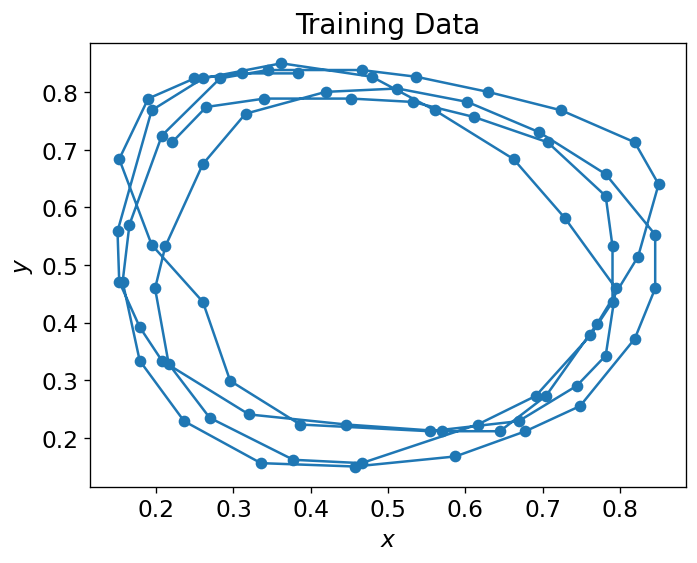

In [2]:
data = np.genfromtxt('data/mouse_circle_data.csv', delimiter=',')

# We want to downsample by a bit
dsFactor = 4 # integer

# We also normalize, so that the data can all be generated
# as the output of a sigmoid. This means between .15 - .85 
# by default.
xArr = normalize(data[::dsFactor,0])
yArr = normalize(data[::dsFactor,1])

plt.plot(xArr, yArr, '-o')
plt.title('Training Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## Load Model

If you've already trained a model, you can load it in from here. Note that the learning curve will not be saved, so this will be empty.

In [5]:
numEpochs = 2000

model = load('models/circle.npz')

inputArr = np.array(list(zip(xArr, yArr)))[:-1]
targetArr = np.array(list(zip(xArr, yArr)))[1:]
contextArr, outputArr = model.forwardSequence(inputArr)

errorArr = np.ones(numEpochs) # list to store errors

AttributeError: 'NoneType' object has no attribute 'lower'

## Train Model

This will train the model from scratch, for the set number of epochs and network hyperparameters.

In [10]:
numEpochs = 3000

model = ElmanNetwork(inputDim=2,
                     contextDim=20,
                     outputDim=2,
                     learningRate=5e-2,
                     optimizer='adam')

inputArr = np.array(list(zip(xArr, yArr)))[:-1]
targetArr = np.array(list(zip(xArr, yArr)))[1:]
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()
    
#save(model, 'models/circle.npz')

100%|██████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 381.40it/s]


Examine the results of the training, including the learning curve, $x$ and $y$ comparison, and phase space comparison to the target data.

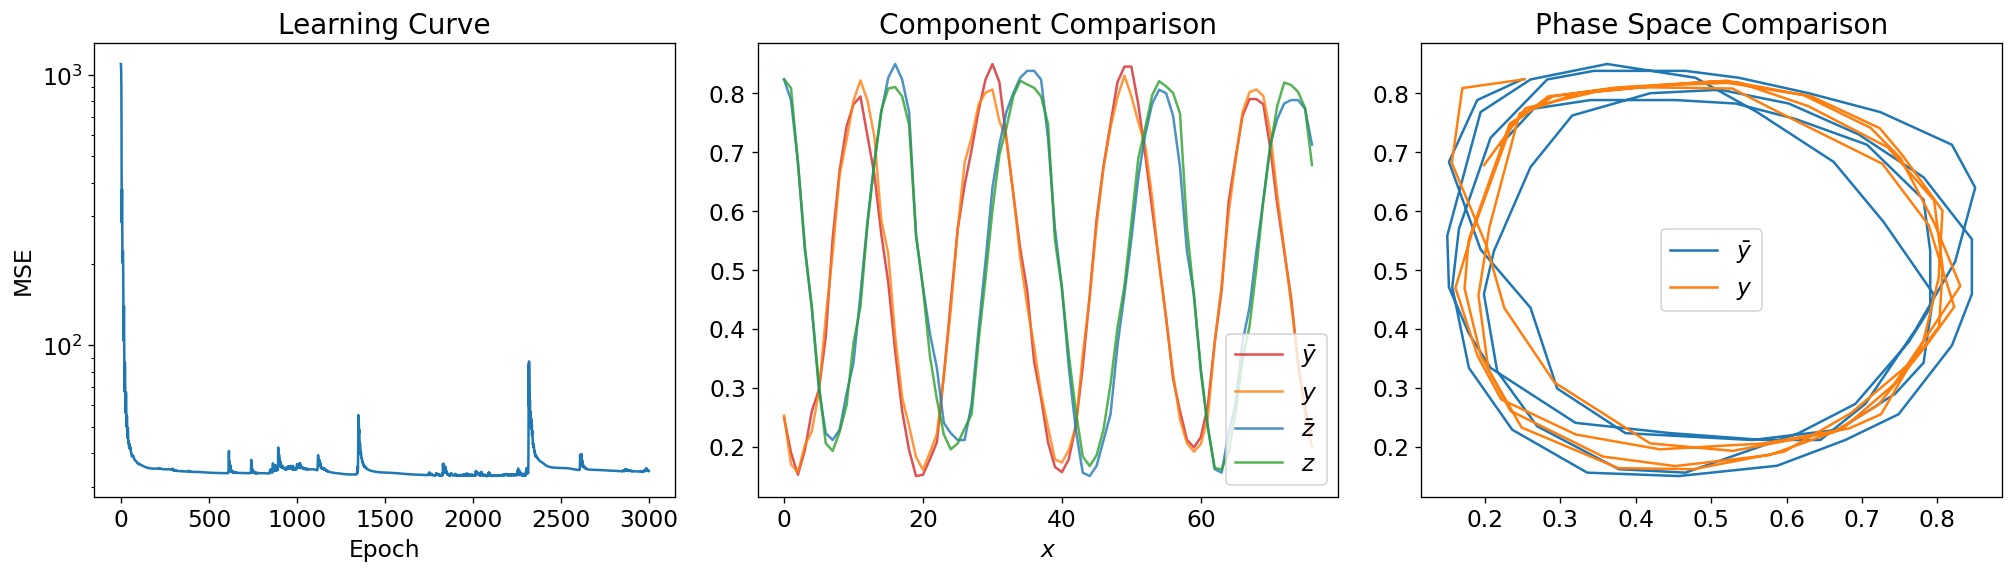

In [11]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

ax[1].plot(targetArr[1:,0], alpha=.8, c='tab:red', label=r'$ \bar y $')
ax[1].plot(outputArr[1:,0], alpha=.8, c='tab:orange', label='$ y $')
ax[1].plot(targetArr[1:,1], alpha=.8, c='tab:blue', label=r'$ \bar z $')
ax[1].plot(outputArr[1:,1], alpha=.8, c='tab:green', label='$ z $')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_title('Component Comparison')

ax[2] = fig.add_subplot(1, 3, 3)

ax[2].set_title('Phase Space Comparison')
ax[2].plot(targetArr[1:,0], targetArr[1:,1], label=r'$\bar y$')
ax[2].plot(outputArr[1:,0], outputArr[1:,1], label=r'$y$')
ax[2].legend()

fig.tight_layout()

plt.show()

## Closed Loop Prediction

Given an initial point, we predict the next one, and then feed that back into the network to investigate the steady-state behavior of the network.

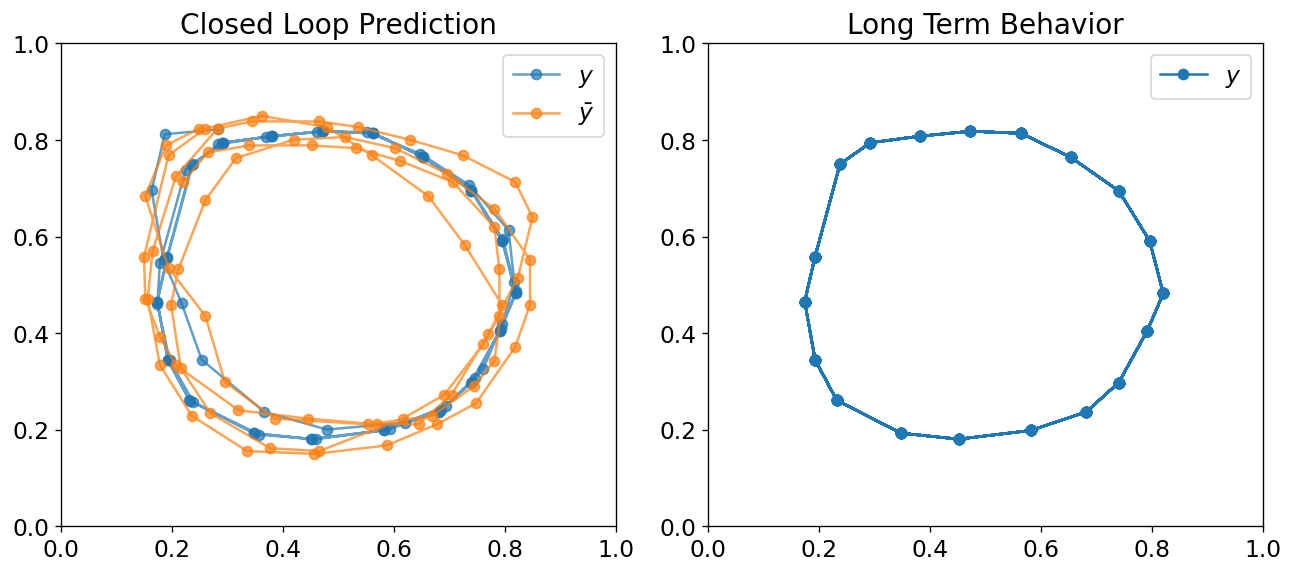

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

nSteps = 10000

predictArr = model.predict([xArr[0], yArr[0]], nSteps)

ax[0].plot(predictArr[1:targetArr.shape[0],0], predictArr[1:targetArr.shape[0],1], '-o', alpha=.7, label='$ y $')
ax[0].plot(targetArr[1:,0], targetArr[1:,1], '-o', alpha=.7, label=r'$\bar y$')
ax[0].legend()
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_title('Closed Loop Prediction')

ax[1].plot(predictArr[-nSteps//30:,0], predictArr[-nSteps//30:,1], '-o', label='$ y $')
ax[1].legend()
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_title('Long Term Behavior')

fig.tight_layout()
plt.savefig('images/circle_cl.png')
plt.show()

## Initial State Sensitivity

Does the output of the network change based on where on the circle it starts?

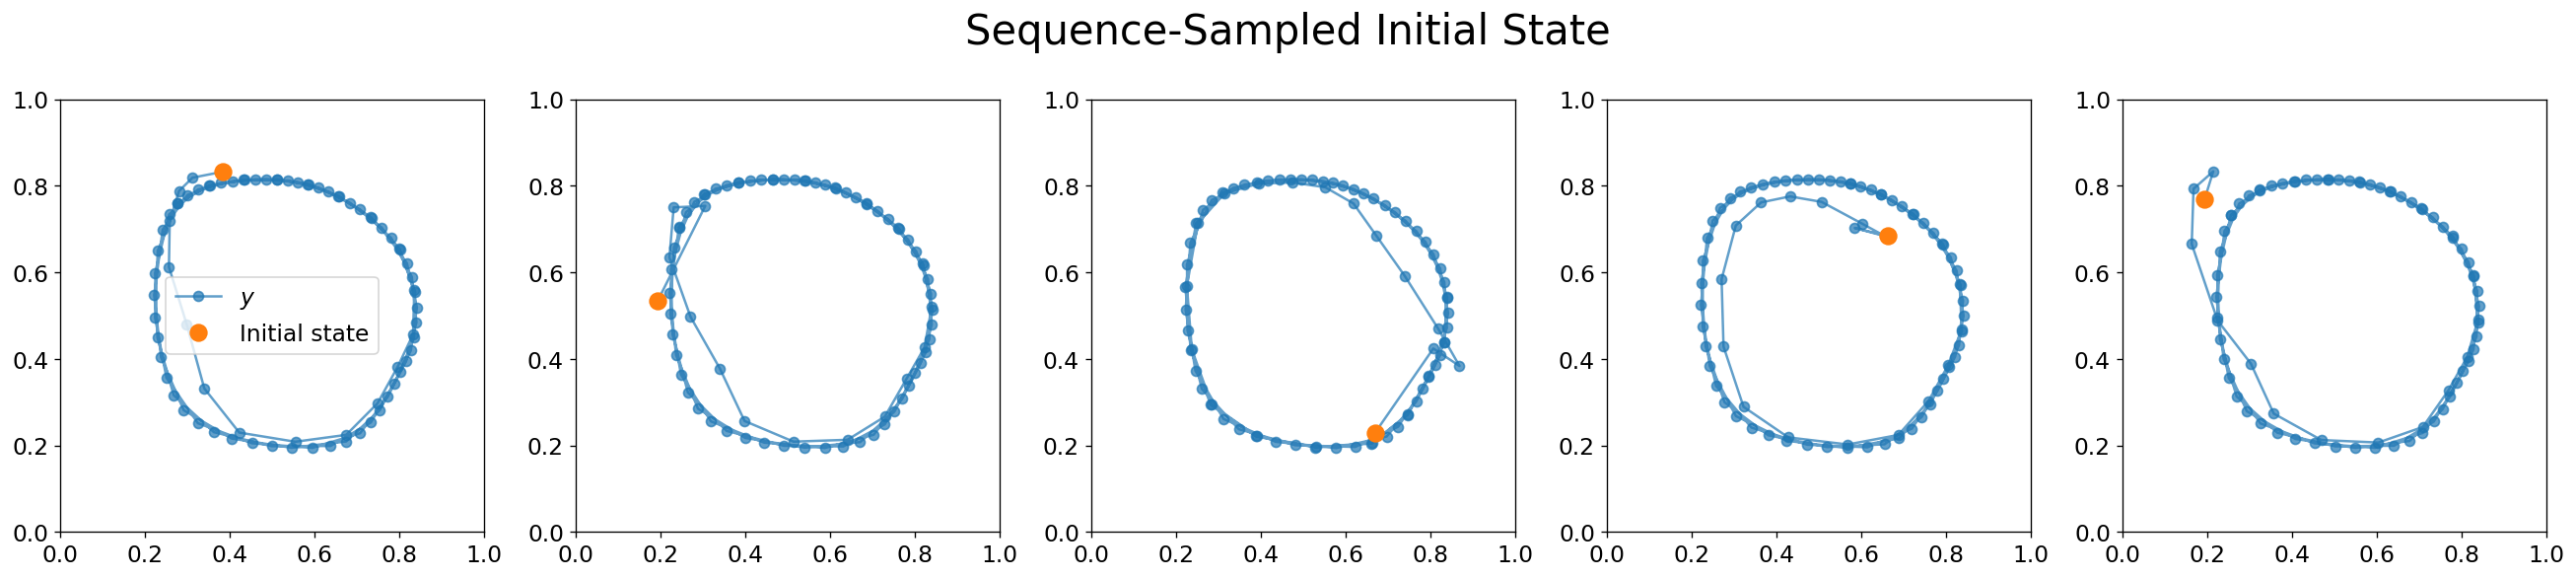

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(22,5))

stateJumpIncrement = 5

for i in range(5):

    nSteps = 1000

    predictArr = model.predict([xArr[i*stateJumpIncrement], yArr[i*stateJumpIncrement]], predictionSteps=nSteps)

    
    ax[i].plot(predictArr[:targetArr.shape[0],0], predictArr[:targetArr.shape[0],1], '-o', alpha=.7, label='$ y $')
    ax[i].plot(xArr[i*stateJumpIncrement], yArr[i*stateJumpIncrement], 'o', markersize=10, label='Initial state')

    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])

ax[0].legend()
fig.suptitle('Sequence-Sampled Initial State', fontsize=25)
fig.tight_layout()
plt.show()

How about if we give it a point that isn't on the circle at all?

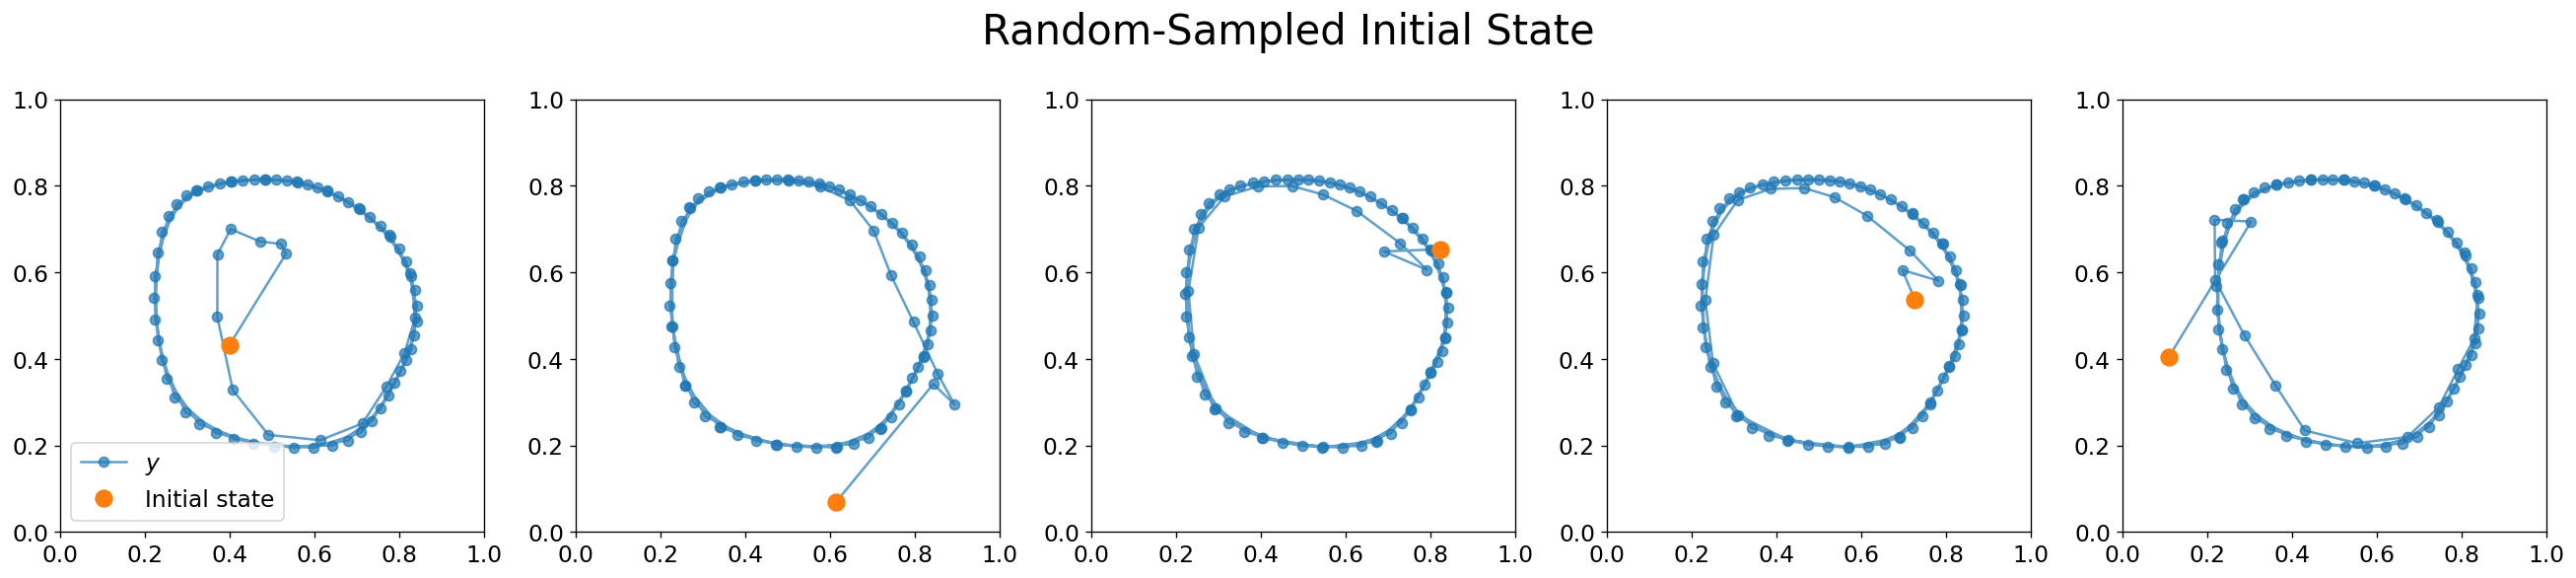

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(22,5))

initialPoints = np.random.uniform(0, 1, size=(5,2))

for i in range(5):

    nSteps = 1000

    predictArr = model.predict(initialPoints[i], predictionSteps=nSteps)

    
    ax[i].plot(predictArr[:targetArr.shape[0],0], predictArr[:targetArr.shape[0],1], '-o', alpha=.7, label='$ y $')
    ax[i].plot(initialPoints[i][0], initialPoints[i][1], 'o', markersize=10, label='Initial state')

    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])

ax[0].legend()
fig.suptitle('Random-Sampled Initial State', fontsize=25)
fig.tight_layout()
plt.show()